# Popular Data Science Questions
### A guided project from Dataquest.io

In this guided project I am acting as an analyst working for a company that creates content regarding data science. Books, articles, videos or interactive text platforms. I am tasked to figure out the best content to write about. 

Since Stack Overflow is a core for developmnent questions, I begin my search there, noticing that there is a stack exchange site for data science! I will use this platform to leverage ideas for content for my company to write about. 

### Initial Impressions:
I could web-scrape the site to get the content and data that I need, but that process is arduous. I note that tehre is a link to query the stack-exchange sites entirely (https://data.stackexchange.com/datascience/query/new). Since SO uses tags, I decide that pulling data regarding tags of questions is a good place to start. Using the query tool I can see that the "posts" table has most of the data that I might want. 

I use the following query to get the data from the SO query tool. 

```SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount FROM Posts;```

I take that data and import it into Pandas below. 




In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('QueryResults.csv')
data.shape

(50000, 8)

In [19]:
data.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,38015,1,2018-09-09 22:07:26,0,61.0,<python><logistic-regression>,1.0,NaN
1,38016,1,2018-09-09 22:56:40,0,267.0,<python><r><visualization><graphs><javascript>,2.0,1.0
2,38017,2,2018-09-09 23:59:38,1,NaN,NaN,NaN,NaN
3,38018,2,2018-09-10 00:42:50,2,NaN,NaN,NaN,NaN
4,38019,1,2018-09-10 03:21:18,1,2759.0,<machine-learning>,2.0,NaN
5,38020,1,2018-09-10 06:11:15,5,14875.0,<keras><tensorflow><cross-validation>,2.0,4.0
6,38021,1,2018-09-10 06:51:59,0,7257.0,<apache-spark><pyspark><dataframe>,1.0,NaN
7,38022,1,2018-09-10 07:07:31,5,426.0,<machine-learning><nlp><rnn><word2vec>,1.0,NaN
8,38023,1,2018-09-10 07:26:39,0,54.0,<machine-learning>,1.0,NaN
9,38024,1,2018-09-10 07:28:05,2,47.0,<machine-learning><dataset><machine-learning-m...,0.0,NaN


In [20]:
data.dtypes

Id                 int64
PostTypeId         int64
CreationDate      object
Score              int64
ViewCount        float64
Tags              object
AnswerCount      float64
FavoriteCount    float64
dtype: object

### Data Impressions
We can see a few things from this data:
 - There are a LOT of posts that do not have any favourites
 - There are some posts without answers
 - There are some posts without tags (they may also be without views)
 - The tags column type is object. We may need to parse these. 
 
_Tags column is most likely the key to our research question. We need to develop a way to rank each tag by some kind of popularity index. The most popular tags will be the ones that we should develop content around_

In [21]:
#Set the CreationDate to a datetime
data['CreationDate'] = pd.to_datetime(data['CreationDate'], format="%Y-%m-%d", errors='coerce')
data.dtypes

Id                        int64
PostTypeId                int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount               float64
Tags                     object
AnswerCount             float64
FavoriteCount           float64
dtype: object

In [22]:
#Fix the Tags field 
data['Tags'] = data['Tags'].str.replace('><', ',')
data['Tags'] = data['Tags'].str.replace('>', '')
data['Tags'] = data['Tags'].str.replace('<', '')
data['Tags'] = data['Tags'].str.split(',')

#drop any rows where the tags are NaN
data = data[data['Tags'].notna()]
data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,38015,1,2018-09-09 22:07:26,0,61.0,"[python, logistic-regression]",1.0,NaN
1,38016,1,2018-09-09 22:56:40,0,267.0,"[python, r, visualization, graphs, javascript]",2.0,1.0
4,38019,1,2018-09-10 03:21:18,1,2759.0,[machine-learning],2.0,NaN
5,38020,1,2018-09-10 06:11:15,5,14875.0,"[keras, tensorflow, cross-validation]",2.0,4.0
6,38021,1,2018-09-10 06:51:59,0,7257.0,"[apache-spark, pyspark, dataframe]",1.0,NaN


Great, now I have separated the tags into lists of tags. I have also changed the creation date to datetime format for easier parsing

### Creating proxies for tag popularity
Now we want to see how popular each tag is. We can use different proxies for this:
 - How many times the tag was used overall
 - How many times a question with that tag was viewed

In [23]:
#How many times does a tag get USED?

#Create a dictionary of all tags, then find the ones with the most count
tagCounts = {}

def parseTags(row): 
    tags = row['Tags']
    for tag in tags :
        if tag in tagCounts :
            tagCounts[tag] += 1
        else :
            tagCounts[tag] = 1

#Run the function on each row
data.apply(parseTags, axis=1)

#sort the dictionary
tagCounts = sorted(tagCounts.items(), key=lambda x:x[1], reverse=True)
for i in range(0,10) :
    print(tagCounts[i])

('machine-learning', 7243)
('python', 4239)
('neural-network', 3009)
('deep-learning', 3006)
('classification', 2135)
('keras', 1879)
('nlp', 1533)
('scikit-learn', 1463)
('tensorflow', 1408)
('time-series', 1103)


In [24]:
# How many times does a tag get VIEWED?

#Create a dictionary of all tags, then find the ones with the most views
tagViews = {}

def parseViews(row) :
    tags = row['Tags']
    views = row['ViewCount']
    for tag in tags :
        if tag in tagViews :
            tagViews[tag] += views
        else : 
            tagViews[tag] = views

#run the function on each row
data.apply(parseViews, axis=1)

#sort the dictionary
tagViews = sorted(tagViews.items(), key=lambda x:x[1], reverse=True)
for i in range(0,10) :
    print(tagViews[i])

('machine-learning', 13020860.0)
('python', 12910275.0)
('neural-network', 6306019.0)
('deep-learning', 5612304.0)
('pandas', 5106267.0)
('scikit-learn', 4370001.0)
('keras', 3888898.0)
('classification', 2683773.0)
('r', 2680767.0)
('tensorflow', 2379462.0)


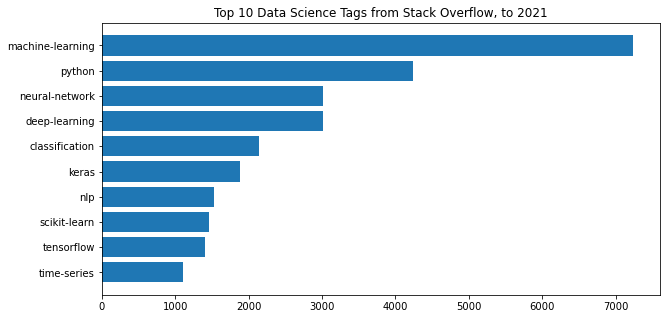

In [38]:
#plot them
fig, ax = plt.subplots(figsize =(10,5))

#prep the keys and values from the list of key-valyes (it seems that sorting the dicitonary returned a list, so need to handle that)
countKeys = []
countValues = []
for i in range(0,10) :
    cur = tagCounts[i]
    countKeys.insert(0,cur[0])
    countValues.insert(0,cur[1])

plt.barh(countKeys, countValues)
plt.title('Top 10 Data Science Tags from Stack Overflow, to 2021')
plt.show()

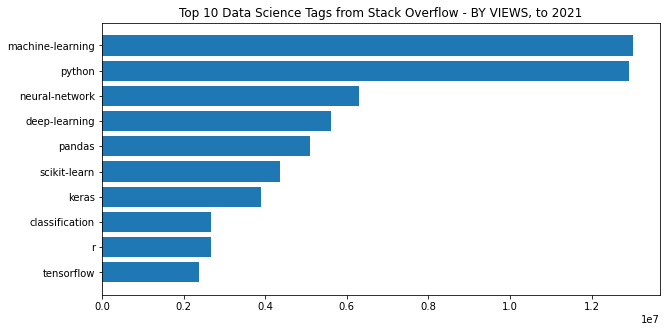

In [40]:
#plot them
fig, ax = plt.subplots(figsize =(10,5))

#prep the keys and values from the list of key-valyes (it seems that sorting the dicitonary returned a list, so need to handle that)
viewKeys = []
viewValues = []
for i in range(0,10) :
    cur = tagViews[i]
    viewKeys.insert(0,cur[0])
    viewValues.insert(0,cur[1])

plt.barh(viewKeys, viewValues)
plt.title('Top 10 Data Science Tags from Stack Overflow - BY VIEWS, to 2021')
plt.show()

### Observations
So we can see that by either Views or Cumulative tag counts, the most popular topics are: 
 - Machine Learning
 - Python
 - Neural Networks
 - Deep Learning
 
What we can determine then, is that these 4 topics are continually the most popular in data-science oriented stack overflow. We might consider that these are topics that would generate lots of interest in content development. 


#### _Potential next steps_
_We might also consider that "Pandas" appears only a few spaces below "Python" and from our own knowledge we know that these are related. We should realize then, that Pandas/Python might be a very important topic to cover, even though pandas isn't explicitly a top tag, it is implied to be super important._ 

_We won't go into exploring these relationships here, but one way would be to identify which tags are commonly used together (posts can have multiple tags). By identifying common cross-tagged posts, we can help to better identify the relationships between different tags_
<br>